In [1]:
import gc
import torch
from bs4 import BeautifulSoup as BS
from typing import List, TypedDict

from pydantic import BaseModel, Field
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader
from langchain_openai import ChatOpenAI
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END

In [2]:
url = "https://docs.langchain.com/oss/python/langchain/overview#langchain-expression-language-lcel"

loader = RecursiveUrlLoader(
    url=url,
    max_depth=20,
    extractor=lambda x: BS(x, 'html.parser').text
)

In [21]:
docs = loader.load()
docs_sorted = sorted(docs, key=lambda x: x.metadata['source'])[:70]
docs_reversed = list(reversed(docs_sorted))

concatenated_content = '\n\n\n --- \n\n\n'.join(doc.page_content for doc in docs_sorted)

In [22]:
len(docs_sorted)

70

In [23]:
system = '''
당신은 LCEL(Langchain Expression Language) 전문가인 코딩 어시스턴트입니다.
다음은 필요한 LCEL 문서 전문입니다.:
-------------------
{context}
-------------------
위에 제공된 문서를 기반으로 사용자 질문에 답변하세요.
제공하는 코드는 실행 가능해야 하며, 필요한 모든 import문과 변수들이 정의되어 있어야 합니다.
답변을 다음과 같은 구조로 작성하세요.:
1. prefix: 문제와 접근 방식에 대한 설명
2. imports: 코드 블록 import문
3. code: import문을 제외한 코드 블록
4. description: 질문에 대한 코드 스키마

다음은 사용자의 질문입니다.:
'''

code_gen_prompt = ChatPromptTemplate.from_messages(
    [('system', system), ('placeholder', "{messages}")]
)

llm_gen = ChatOpenAI(model='gpt-4o-mini', temperature=0)

In [24]:
class Code(BaseModel):
    prefix: str = Field(description='문제와 접근 방식에 대한 설명')
    imports: str = Field(description='코드 블록 import문')
    code: str = Field(description='import문을 제외한 코드 블록')
    description: str = Field(description='질문에 대한 코드 스키마')

In [25]:
code_gen_chain = code_gen_prompt | llm_gen.with_structured_output(Code)

In [26]:
question = 'LCEL로 RAG 체인을 어떻게 만들어?'
solution = code_gen_chain.invoke(
    {'context':concatenated_content, 'messages':[('user', question)]}
)
print(solution.prefix)
print(solution.imports)
print(solution.code)
print(solution.description)

RAG(정보 검색 기반 생성) 체인은 정보 검색과 생성 모델을 결합하여 사용자가 질문할 때 관련 정보를 검색하고 그 정보를 바탕으로 응답을 생성하는 방식입니다. LCEL을 사용하여 RAG 체인을 구축하는 방법은 다음과 같습니다.
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter

# 필요한 라이브러리들을 import 합니다.
# 1. 문서 로드 및 전처리
loader = TextLoader('path/to/your/documents')  # 문서 경로를 지정합니다.
documents = loader.load()

# 2. 텍스트 분할
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
texts = text_splitter.split_documents(documents)

# 3. 임베딩 생성
embeddings = OpenAIEmbeddings()

# 4. 벡터 스토어 생성
vectorstore = FAISS.from_documents(texts, embeddings)

# 5. RAG 체인 생성
llm = OpenAI(model_name='gpt-3.5-turbo')
qa_chain = RetrievalQA.from_chain_type(llm=llm, chain_type='stuff', retriever=vectorstore.as_retriever())

# 6. 질문에 대한 응답 생성
query = "What is the capital of 

In [27]:
class GraphState(TypedDict):
    error: str
    messages: List
    generation: str
    iterations: int

In [28]:
def generate(state):
    print('---generate---')

    messages = state['messages']
    iterations = state['iterations']
    error = state.get('error', 'no')

    if error == 'yes':
        messages += [
            ('user', '다시 시도해보세요. 출력 결과를 prefix, imports, code block으로 구조화하기 위해 코드 도구를 호출하세요.:')
        ]
    code_solution = code_gen_chain.invoke(
        {'context':concatenated_content, 'messages':messages}
    )
    messages += [
        ('assistant', f'{code_solution.prefix} \n Imports: {code_solution.imports} \n Code:{code_solution.code}')
    ]
    iterations += 1

    return {'messages':messages, 'generation': code_solution, 'iterations':iterations}

In [29]:
def code_check(state):
    print('---code check---')

    messages = state['messages']
    code_solution = state['generation']
    iterations = state['iterations']

    imports = code_solution.imports
    code = code_solution.code

    try:
        exec(imports)
    except Exception as e:
        print('--import check: Failure--')
        error_message = [('user', f'당신의 코드는 import 테스트를 실패했습니다.: {e}')]
        messages += error_message

        return {'messages':messages, 'generation':code_solution, 'iterations':iterations, 'error':'yes'}
    
    try:
        exec(imports + '\n' + code)
    except:
        print('--code block check: Failure')
        error_message = [('user', f'당신의 코드는 실행 테스트를 실패했습니다.: {e}')]
        messages += error_message

        return {'messages':messages, 'generation':code_solution, 'iterations':iterations, 'error':'yes'}
    
    print('--Success--')

    return {'messages':messages, 'generation':code_solution, 'iterations':iterations, 'error':'no'}

In [31]:
def reflect(state):
    print('---generate code solution---')

    messages = state['messages']
    iterations = state['iterations']
    code_solution = state['generation']

    reflections = code_gen_chain.invoke(
        {'context':concatenated_content, 'messages':messages}
    )
    messages += [('assistant', f'여기 오류를 반영한 코드입니다: {reflections}')]

    return {'messages':messages, 'generations':code_solution, 'iterations':iterations}

In [32]:
flag = 'do not reflect'

def decide_to_finish(state):
    error = state['error']
    iterations = state['iterations']

    if error == 'no' or iterations == 3:
        print('--finish--')
        return 'end'
    else:
        print('--retry--')
        if flag is True:
            return 'reflect'
        else:
            return 'generate'

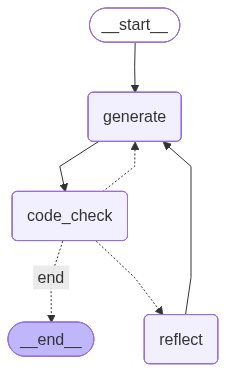

In [33]:
workflow = StateGraph(GraphState)

workflow.add_node('generate', generate)
workflow.add_node('code_check', code_check)
workflow.add_node('reflect', reflect)

workflow.set_entry_point('generate')
workflow.add_edge('generate', 'code_check')
workflow.add_conditional_edges(
    'code_check',
    decide_to_finish,
    {'end':END, 'reflect':'reflect', 'generate':'generate'}
)
workflow.add_edge('reflect', 'generate')

app = workflow.compile()
app

In [34]:
question = '문자열을 runnable 객체에 직접 전달하고, 이를 사용하여 내 프롬프트에 필요한 입력을 구성하려면 어떻게 해야 하나요?'

app.invoke({'messages':[('user', question)], 'iterations':0})

---generate---
---code check---
--import check: Failure--
--retry--
---generate---
---code check---
{'messages': [{'role': 'user', 'content': 'What is the weather in San Francisco?'}]}
--Success--
--finish--


{'error': 'no',
 'messages': [('user',
   '문자열을 runnable 객체에 직접 전달하고, 이를 사용하여 내 프롬프트에 필요한 입력을 구성하려면 어떻게 해야 하나요?'),
  ('assistant',
   '이 문제를 해결하기 위해, 우리는 LangGraph의 runnable 객체를 사용하여 문자열을 직접 전달하고, 이를 통해 프롬프트에 필요한 입력을 구성할 수 있습니다. 이를 위해, 먼저 runnable 객체를 정의하고, 그 객체를 사용하여 입력을 생성하는 방법을 보여주는 코드를 작성하겠습니다. \n Imports: from langchain_core.runnables import Runnable, RunnableMap\nfrom langchain_core.messages import Messages \n Code:class StringRunnable(Runnable):\n    def invoke(self, input_string: str) -> dict:\n        # 입력 문자열을 사용하여 메시지 형식으로 변환\n        return {\n            \'messages\': [\n                {\'role\': \'user\', \'content\': input_string}\n            ]\n        }\n\n# StringRunnable 객체 생성\nstring_runnable = StringRunnable()\n\n# 문자열을 runnable 객체에 전달하여 입력 구성\ninput_string = "What is the weather in San Francisco?"\ninput_data = string_runnable.invoke(input_string)\n\n# 결과 출력\nprint(input_data)'),
  ('user',
   "당신의 코드는 import 테스트를 실패했습니다.: cannot import name 'Messages' from 'lan